In [63]:
import numpy as np
from io_utils import *
A = loadGraph('facebook/0.edges', 'u')
A = removeIsolatedNodes(A)

B, P = permuteNoiseMat(A,is_perm =False, has_noise =False)
B_noise, P = permuteNoiseMat(A,is_perm =False, has_noise =True)

writeEdgesToFile('metadata/A.edges', A)
writeEdgesToFile('metadata/B.edges', B)
writeEdgesToFile('metadata/B_noise.edges', B_noise)


In [64]:
from attr_utils import *

attributesA = getUndirAttribute('metadata/A.edges')
with open('metadata/attributesA', 'w') as f:
    for index, row in attributesA.iterrows():
        f.write(str(attributesA.ix[index]))

attributesB = getUndirAttribute('metadata/B.edges')
with open('metadata/attributesB', 'w') as f:
    for index, row in attributesB.iterrows():
        f.write(str(attributesB.ix[index]))

attributesB_noise = getUndirAttribute('metadata/B_noise.edges')
with open('metadata/attributesB_noise', 'w') as f:
    for index, row in attributesB_noise.iterrows():
        f.write(str(attributesB_noise.ix[index]))

Degree


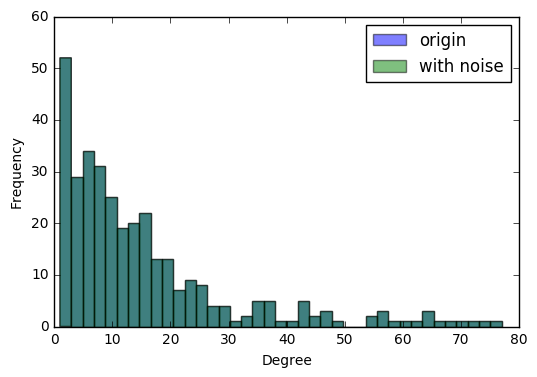

NodeBetweennessCentrality


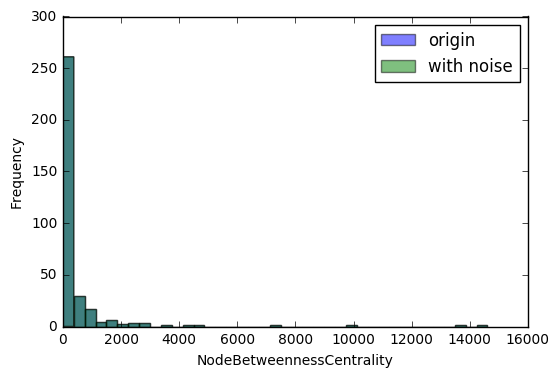

FarnessCentrality


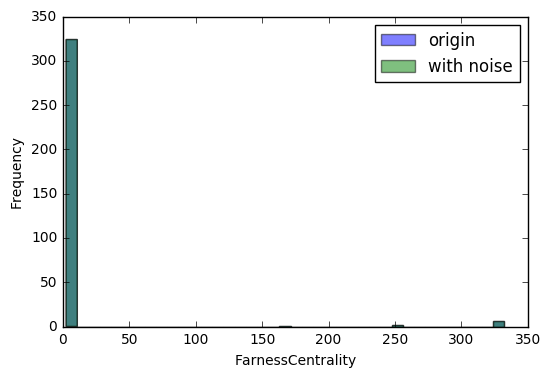

PageRank


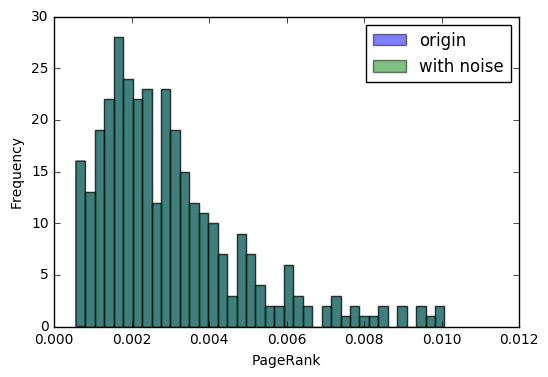

NodeEccentricity


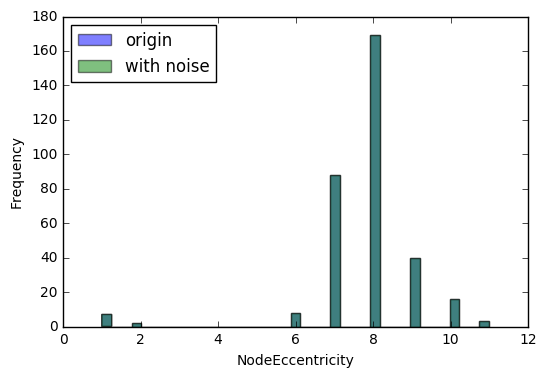

EgonetDegree


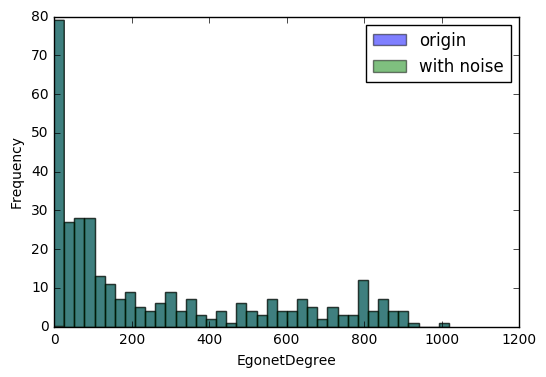

AvgNeighborDeg


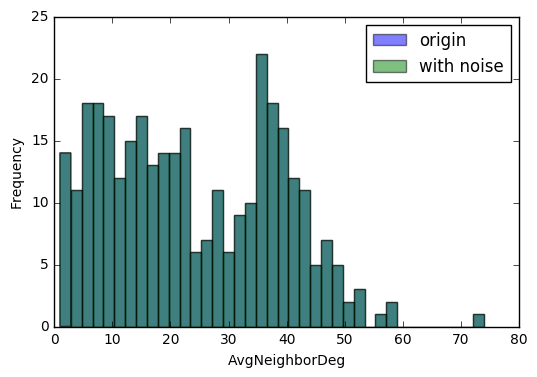

EgonetConnectivity


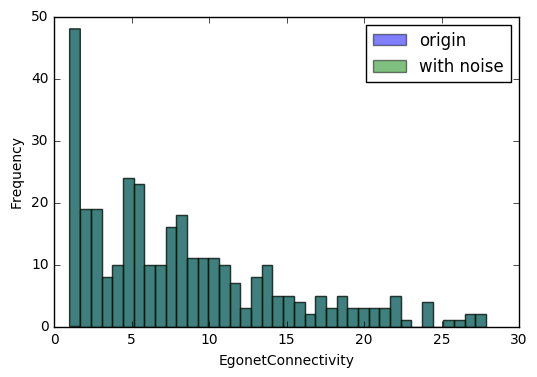

In [65]:
# plot attributes distributin against noise
import matplotlib.pyplot as plt

attributes = ['Degree', 'NodeBetweennessCentrality', 'FarnessCentrality', 'PageRank', 'NodeEccentricity'
              , 'EgonetDegree', 'AvgNeighborDeg', 'EgonetConnectivity']
plt.clf()
for attr in attributes:
    print attr
    plt.figure()
    bins = np.linspace(min(min(attributesA[attr]), min(attributesB[attr])), max(max(attributesA[attr]), max(attributesB[attr])), 40)
    plt.hist(attributesA[attr], bins, alpha=0.5, label='origin')
    plt.hist(attributesB[attr], bins, alpha=0.5, label='with noise')
    plt.xlabel(attr)
    plt.ylabel('Frequency')
    plt.legend(loc='best')
    plt.show()

In [66]:
from attr_utils import *
from lsh_utils import *

attributes = ['Degree', 'NodeBetweennessCentrality', 'FarnessCentrality', 'PageRank', 'NodeEccentricity']

for i in range(len(attributes)):
    print 'KL Divergence of %s between normal and noised' %(attributes[i]), KL_sim(attributesB[attributes[i]], attributesB_noise[attributes[i]])


KL Divergence of Degree between normal and noised 0.728202202584
KL Divergence of NodeBetweennessCentrality between normal and noised 137.089678015
KL Divergence of FarnessCentrality between normal and noised 454.502135543
KL Divergence of PageRank between normal and noised 2.50079307344
KL Divergence of NodeEccentricity between normal and noised 6.93349803638


In [70]:
from lsh_utils import *

combineAB = selectAndCombine(attributesA, attributesB_noise)

bandDeg = ['Degree','PageRank','NodeBetweennessCentrality','FarnessCentrality']
bucketDeg = generateCosineBuckets(selectAndCombine(attributesA, attributesB_noise, bandDeg), 20)
with open('metadata/buckets-band-1', 'w') as f:
    for k, v in bucketDeg.items():
        f.write(str(k) + str(v) + '\n')
print len(bucketDeg.items())

bandEdge = ['EgonetDegree', 'AvgNeighborDeg', 'EgonetConnectivity']
bucketEdge = generateCosineBuckets(selectAndCombine(attributesA, attributesB_noise, bandEdge), 20)
with open('metadata/buckets-band-2', 'w') as f:
    for k, v in bucketEdge.items():
        f.write(str(k) + str(v) + '\n')
print len(bucketEdge.items())

bandAll = ['Degree','PageRank', 'NodeBetweennessCentrality','FarnessCentrality', 'NodeEccentricity']
bucketAll = generateCosineBuckets(selectAndCombine(attributesA, attributesB_noise, bandAll), 20)
print len(bucketAll.items())

buckets = [bucketDeg, bucketEdge]

70
28
36


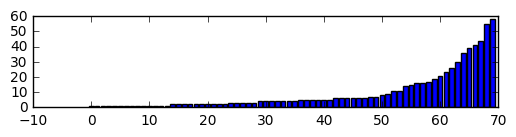

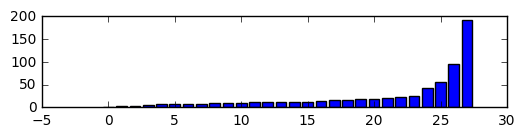

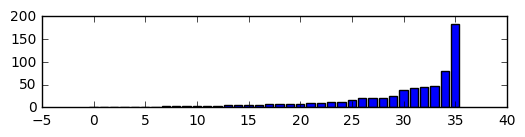

In [71]:
#plot cosine bucket distribution
pair_count_dict = combineBucketsBySum(buckets, combineAB, 'metadata/A.edges')
            
import matplotlib.pyplot as plt
plt.subplot(311)
plotBucketDistribution(bucketDeg)
plt.subplot(313)
plotBucketDistribution(bucketEdge)
plt.subplot(313)
plotBucketDistribution(bucketAll)
plt.show()

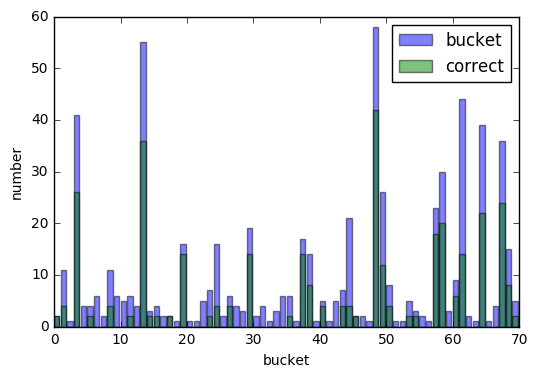

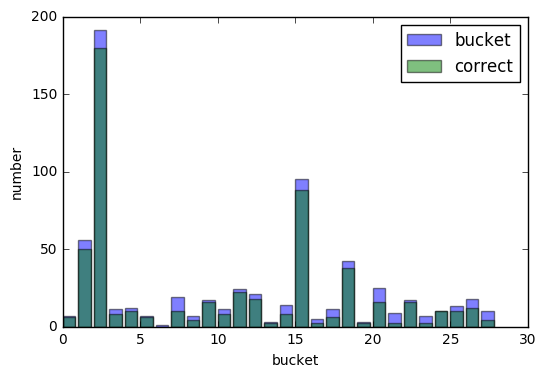

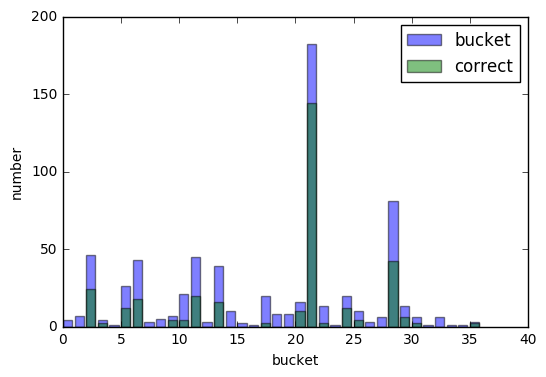

In [72]:
# plot cosine bucket correctness
def plotCorrectness(d, n):
    correct = {}
    for v, k in d.items():
        cnt = 0
        for i in k:
            if (i < n):
                if (i + n in k):
                    cnt += 2
            else:
                break
        correct[v] = cnt
    plt.clf
    plt.figure()
    plt.bar(range(len(d)), [len(v) for k,v in d.items()], alpha=0.5, label='bucket', color='blue')
    plt.bar(range(len(correct)), [correct[k] for k,v in d.items()], alpha=0.5, label='correct', color='green')
    plt.xlabel('bucket')
    plt.ylabel('number')
    plt.legend(loc='best')
    plt.show()
    
plotCorrectness(bucketDeg, attributesA.shape[0])
plotCorrectness(bucketEdge, attributesA.shape[0])
plotCorrectness(bucketAll, attributesA.shape[0])

In [73]:
matching_matrix = computeMatchingMat(attributesA, attributesB_noise, pair_count_dict)
sim_matrix = computeWholeSimMat(attributesA, attributesB_noise)
Ranking = Rank(matching_matrix, P)
Best_ranking = Rank(sim_matrix, P)

In [74]:
print "matching score: %f" %(sum(Ranking)/len(Ranking))
print "matching score upper bound: %f" %(sum(Best_ranking)/len(Best_ranking))
print "percentage of pairs computed: %f" %(len(pair_count_dict)
                                           /float(matching_matrix.shape[0]*matching_matrix.shape[1]/2-matching_matrix.shape[0]))

show_list = [0, 10, 20, 50]
top_k = 5
for i in show_list:
    print "cos sim top %d for node %d:" %(top_k, attributesA['Id'][i])
    print attributesB['Id'][sim_matrix[i].argsort()[-top_k:]].values
    print "matching top %d for node %d:"%(top_k, attributesA['Id'][i])
    print attributesB['Id'][matching_matrix[i].argsort()[-top_k:]].values


matching score: 0.520669
matching score upper bound: 0.515359
percentage of pairs computed: 0.300993
cos sim top 5 for node 1:
[ 77  51  25 170   1]
matching top 5 for node 1:
[  3 125  51  25   1]
cos sim top 5 for node 11:
[201 212  11  97 254]
matching top 5 for node 11:
[133 212  97 284  11]
cos sim top 5 for node 21:
[151 180 266 111  21]
matching top 5 for node 21:
[ 35 180 266 111  21]
cos sim top 5 for node 51:
[ 76   1 138   5  51]
matching top 5 for node 51:
[ 80 168 160 211  89]


In [76]:
bandDeg = ['Degree','PageRank','NodeBetweennessCentrality','FarnessCentrality', 'NodeEccentricity']
bucketDeg = generateEuclideanBuckets(selectAndCombine(attributesA, attributesB_noise, bandDeg), 2)
with open('metadata/euc-buckets-band-1', 'w') as f:
    for k, v in bucketDeg.items():
        f.write(str(k) + str(v) + '\n')
print len(bucketDeg.items())

bandEdge = ['EgonetDegree', 'AvgNeighborDeg', 'EgonetConnectivity']
bucketEdge = generateEuclideanBuckets(selectAndCombine(attributesA, attributesB_noise, bandEdge), 2)
with open('metadata/euc-buckets-band-2', 'w') as f:
    for k, v in bucketEdge.items():
        f.write(str(k) + str(v) + '\n')
print len(bucketEdge.items())

bandAll = ['Degree','PageRank', 'NodeBetweennessCentrality','FarnessCentrality', 'NodeEccentricity']
bucketAll = generateEuclideanBuckets(selectAndCombine(attributesA, attributesB_noise, bandAll), 2)
print len(bucketAll.items())
buckets = [bucketDeg, bucketEdge]

63
42
64


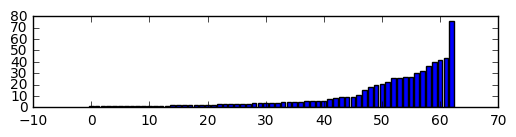

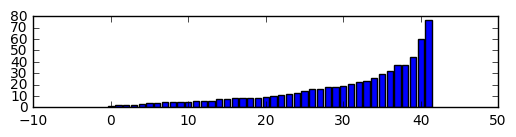

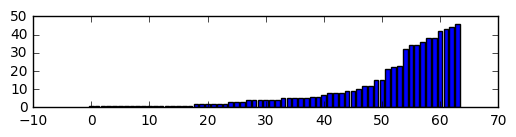

In [77]:
pair_count_dict = combineBucketsBySum(buckets, combineAB, 'metadata/A.edges')
            
import matplotlib.pyplot as plt
plt.subplot(311)
plotBucketDistribution(bucketDeg)
plt.subplot(312)
plotBucketDistribution(bucketEdge)
plt.subplot(313)
plotBucketDistribution(bucketAll)
plt.show()

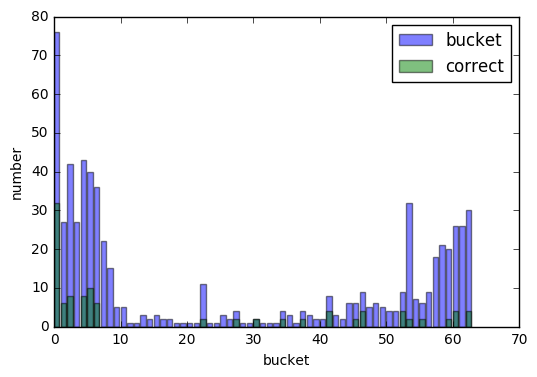

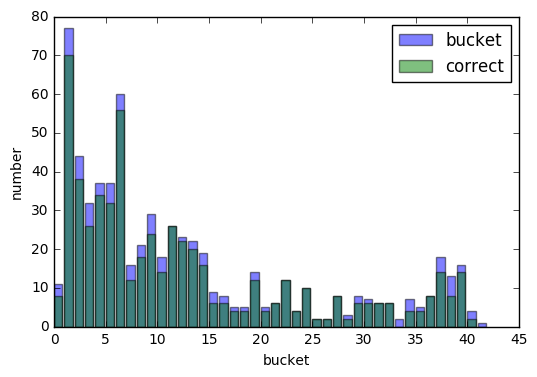

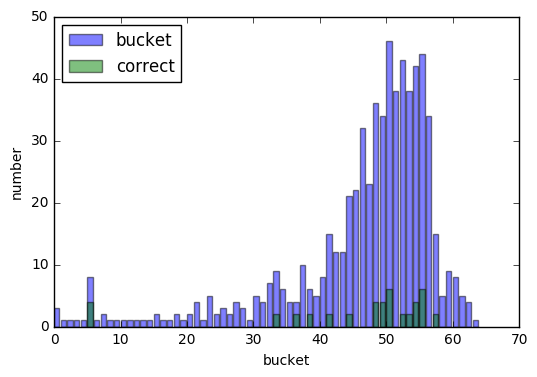

In [78]:
plotCorrectness(bucketDeg, attributesA.shape[0])
plotCorrectness(bucketEdge, attributesA.shape[0])
plotCorrectness(bucketAll, attributesA.shape[0])

In [79]:
matching_matrix = computeMatchingMat(attributesA, attributesB, pair_count_dict)
sim_matrix = computeWholeSimMat(attributesA, attributesB)
Ranking = Rank(matching_matrix, P)
Best_ranking = Rank(sim_matrix, P)

print "matching score: %f" %(sum(Ranking)/len(Ranking))
print "matching score upper bound: %f" %(sum(Best_ranking)/len(Best_ranking))
print "percentage of pairs computed: %f" %(len(pair_count_dict)
                                           /float(matching_matrix.shape[0]*matching_matrix.shape[1]/2-matching_matrix.shape[0]))


matching score: 0.638499
matching score upper bound: 0.996997
percentage of pairs computed: 0.166391
